# Spectrograms

In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.fft import fft
import matplotlib.pyplot as plt

In [2]:
mat = sio.loadmat('data/sampleEEGdata.mat')
EEG = mat['EEG']
srate = EEG['srate'][0][0][0][0]
times = EEG['times'][0][0]
data = EEG['data'][0][0]

print(srate)
print(times.shape)
print(data.shape)

256
(1, 640)
(64, 640, 99)


**Q**: How can I plot signal in time domain using sampling frequency and data?

In the data matrix, the 3rd dimension is of size 99, which represents the number of trials of the EEG experiment. In this case, we're interested in data from any one of the trials.

In [3]:
data = data[:,:,0]
times = times.reshape(-1,1)
print(data.shape)
print(times.shape)

(64, 640)
(640, 1)


Now we're left with a signal that has 64 channels and 640 datapoints. We select the first channel from the list of channels.

In [4]:
ch = data[0,:]
ch.shape

(640,)

This gives the time domain representation of the signal.

Text(0, 0.5, 'Amplitude')

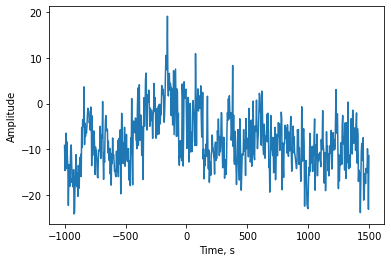

In [5]:
fig, ax = plt.subplots()
ax.plot(times, ch)
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude')

## STFT

Now, we will use FFT to transform the representation of this signal into the frequency domain. More specifically, we apply STFT to produce a spectrogram, which shows how the spectrum of frequencies of a signal varies with time. The colour of the spectrogram represents frequency amplitude.

We now want to perform STFT on 0.5s window of EEG signal. To do this, we first need to know what the window length of 30s is in terms of index.

In [6]:
timewin = 0.5 # in seconds
timewinidx = np.round(timewin/(1/srate)).astype(int)
print(timewinidx)

128


We perform STFT with a Hann window and 50% overlap (default parameter) and linear detrend.

In [7]:
f, t, Zxx = signal.stft(ch, fs=srate, window='hann',
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

This can now be plotted to produce a spectrogram.

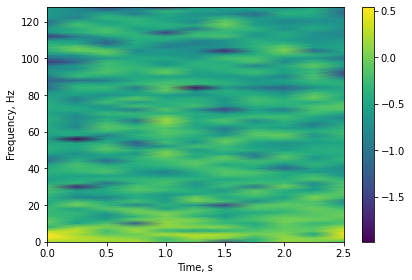

In [8]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')
fig.tight_layout()
fig.savefig('figures/stft_spectrogram.png')

### Detrend

**TODO:** What does detrending do?

We explore how presence of detrending and its variations can impact spectrogram.

Text(0, 0.5, 'Frequency, Hz')

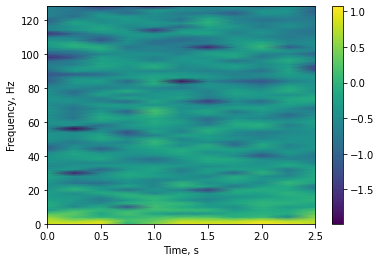

In [9]:
# no detrend
timewin = 0.5 # in seconds
timewinidx = np.round(timewin/(1/srate)).astype(int)

f, t, Zxx = signal.stft(ch, fs=srate, window='hann', nperseg=timewinidx, noverlap=None, 
                        nfft=None, detrend=False, return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')

Linear detrend subtracts the result of a linear least squares fit _of_ data _from_ the data.

Text(0, 0.5, 'Frequency, Hz')

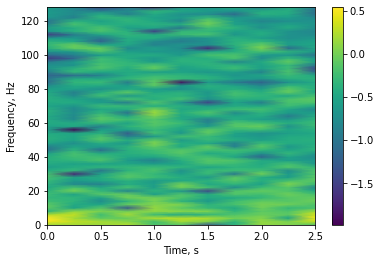

In [10]:
# linear detrend
timewin = 0.5 # in seconds
timewinidx = np.round(timewin/(1/srate)).astype(int)

f, t, Zxx = signal.stft(ch, fs=srate, window='hann', nperseg=timewinidx, noverlap=None, 
                        nfft=None, detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')

Constant detrend subtracts the mean of the data from the data.

Text(0, 0.5, 'Frequency, Hz')

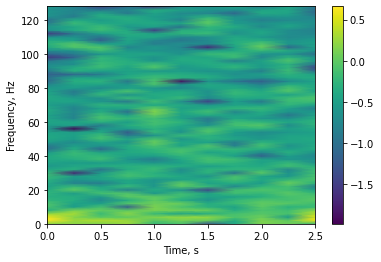

In [11]:
# constant detrend
timewin = 0.5 # in seconds
timewinidx = np.round(timewin/(1/srate)).astype(int)

f, t, Zxx = signal.stft(ch, fs=srate, window='hann', nperseg=timewinidx, noverlap=None, 
                        nfft=None, detrend='constant', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')

### Window size

We now investigate how changing window length affects the spectrogram signature.

The window size of affects the frequency resolution of the signal since frequency resolution of a Fourier transform is defined by the number of points in the signal. The window size should be long enough to capture at least one cycle of the lowest frequency and preferably more than one cycle to increase the signal-to-noise ratio. However, if the window is too large, then we will average over a large number of points and fail to capture transient higher frequency activity.  

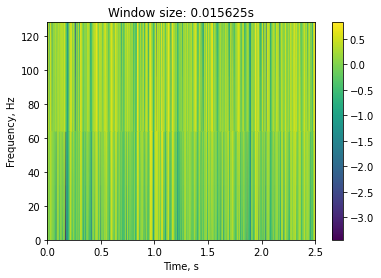

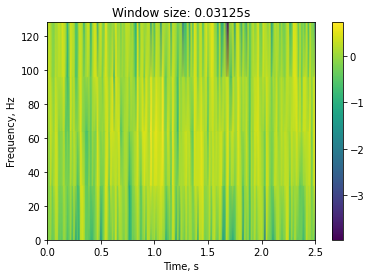

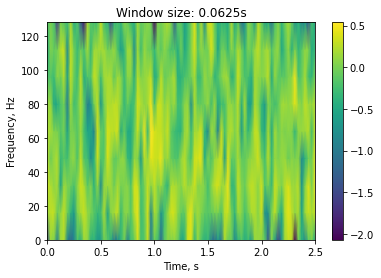

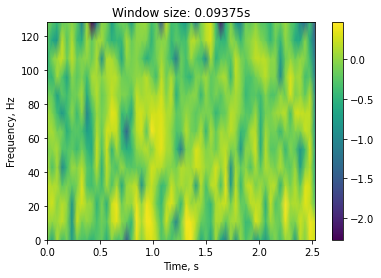

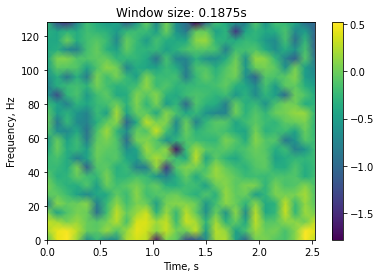

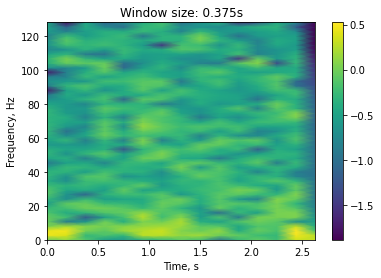

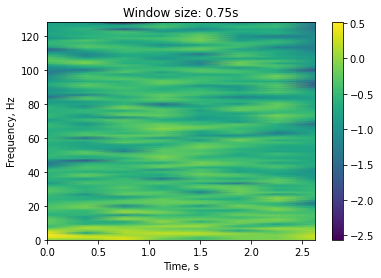

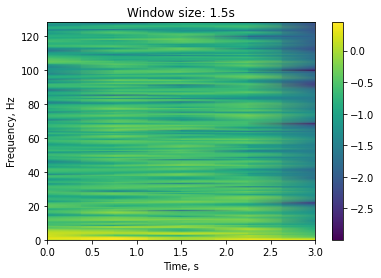

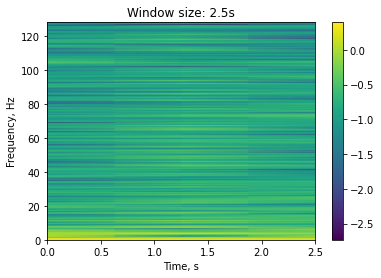

In [12]:
multiples = [4, 8, 16, 24, 48, 96, 192, 384, 640]
for _, multiple in enumerate(multiples):
    timewin = (1/srate)*multiple
    timewinidx = np.round(timewin/(1/srate)).astype(int)
    f, t, Zxx = signal.stft(ch, fs=srate, window='hann', 
                            nperseg=timewinidx, noverlap=None, nfft=None, 
                            detrend='linear', return_onesided=True)
    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
    fig.colorbar(mesh)
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Frequency, Hz')
    ax.set_title(f"Window size: {timewin}s")

### Overlap

The amount of overlap between successive sliding windows also impact the result of the STFT. Overlap improves temporal precision, mitigates signal loss due to window tapering and smoothes the spectrogram plots. Although there is no strict guideline, overlap between 50-90% is recommended by neurologists.

<ipython-input-13-825bb45d09b7>:11: RuntimeWarning: divide by zero encountered in log10
  mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')


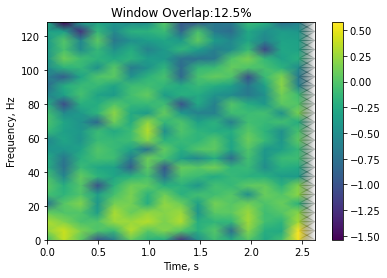

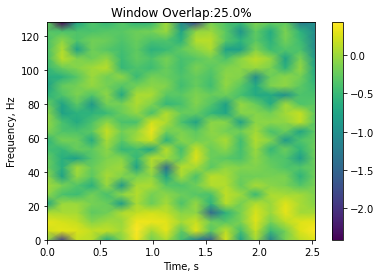

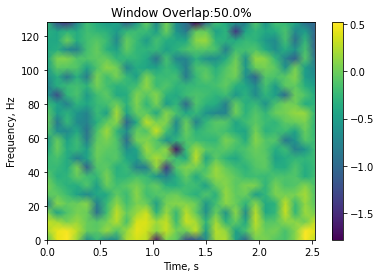

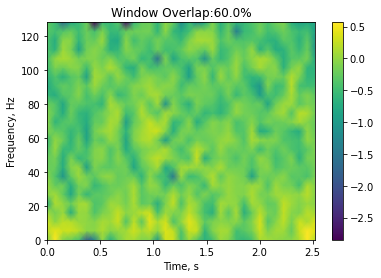

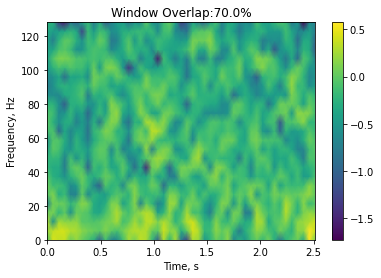

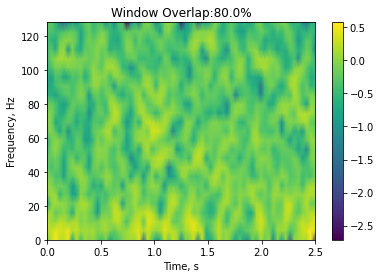

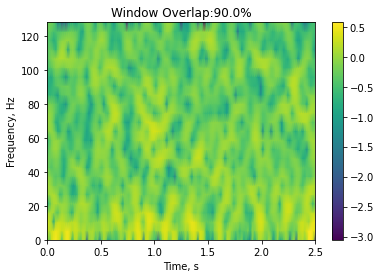

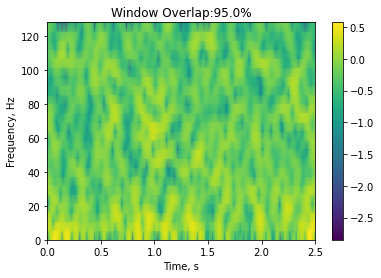

In [13]:
overlap_percs = [.125, .25, .50, .60, .70, .80, .90, .95]

for _, overlap_perc in enumerate(overlap_percs):
    timewin = (1/srate) * 48
    timewinidx = np.round(timewin/(1/srate)).astype(int)
    overlap = np.round(timewinidx * overlap_perc).astype(int)
    f, t, Zxx = signal.stft(ch, fs=srate, window='hann', nperseg=timewinidx, noverlap=overlap, 
                            nfft=None, detrend='linear', return_onesided=True)

    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
    fig.colorbar(mesh)
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Frequency, Hz')
    ax.set_title(f'Window Overlap:{overlap_perc*100}%')